# SPATIAL TRANSFORMERS NETWORKS WITH IMPLEMENTATION IN PYTORCH

*ON MNIST DISTORTED HANDWRITTEN DATASET*

Here, we are importing all the relevant classes and libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

Hereby, we are loading the MNIST distorted handwritten dataset in the form of mini-batches of size 64, with a total of 60,000 training examples and 10,000 test examples to be used as a validation set.

In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(datasets.MNIST(root='.', train=True, download=True, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])), batch_size=64, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(datasets.MNIST(root='.', train=False, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])), batch_size=64, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

### Problem with pooling in CNNs

A desirable property of a system which is able to reason about images is to disentangle object
pose and part deformation from texture and shape. The introduction of local max-pooling layers in
CNNs has helped to satisfy this property by allowing a network to be somewhat spatially invariant
to the position of features. However, due to the typically small spatial support for max-pooling
(e.g. 2 × 2 pixels) this spatial invariance is only realised over a deep hierarchy of max-pooling and
convolutions, and the intermediate feature maps (convolutional layer activations) in a CNN are not
actually invariant to large transformations of the input data . This limitation of CNNs is due
to having only a limited, pre-defined pooling mechanism for dealing with variations in the spatial
arrangement of data.

***The Spatial Transformer mechanism addresses the issues above by providing Convolutional Neural Networks with explicit spatial transformation capabilities***. It possesses 3 defining properties that make it very appealing.

- modular: STNs can be inserted anywhere into existing architectures with relatively small tweaking.

- differentiable: STNs can be trained with backprop allowing for end-to-end training of the models they are injected in.

- dynamic: STNs perform active spatial transformation on a feature map for each input sample as compared to the pooling layer which acted identically for all input samples.


This paper introduces a neural networks module that can learn input-dependent spatial transformations and can be inserted into any neural network. It supports transformations like scaling, cropping, rotations, and non-rigid deformations. Main contributions:

## The spatial transformer network consists of the following:

###  Localization network 

The goal of the localisation network is to spit out the parameters θ of the affine transformation that’ll be applied to the input feature map. More formally, our localisation net is defined as follows:

- input: feature map U of shape (H, W, C)
- output: transformation matrix θ of shape (6,)
- architecture: fully-connected network or ConvNet as well

###  Grid generator that uses the transformation parameters to produce a grid to sample from the input.
    
The grid generator’s job is to output a parametrised sampling grid, which is a set of points where the input map should be sampled to produce the desired transformed output.

### Sampler that produces the output feature map sampled from the input at the grid points.
- Differentiable sampling mechanism
   - The sampling is written in a way such that sub-gradients can be defined with respect to grid coordinates.
   - This enables gradients to be propagated through the grid generator and localization network, and for the network to jointly learn the spatial transformer along with rest of the network.
   
<p>&nbsp;</p>   
A network can have multiple STNs

   - at different points in the network, to model incremental transformations at different levels of abstraction.
   - in parallel, to learn to focus on different regions of interest. For example, on the bird classification task, they show that one STN learns to be a head detector, while the other focuses on the central part of the body.
   
<p>&nbsp;</p> 

In the following code block, we are defining the structure of the model that we intend to use, which includes a regular CNN, along with an STN module consisting of a localizing network, a grid-generator and a sampler, along with the function 'forward' that defines how the information shall flow in a forward pass of the network.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        self.local_net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride = 2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.local_net(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)

        x = nn.ReLU()(F.max_pool2d(self.conv1(x), 2))
        x = nn.ReLU()(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = nn.ReLU()(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)

In the following code block, we define the optimizer for conducting gradient descent, in which we used momentum to enhance training speed. And we have also defined the training and test loops, along with a loss function of cross-entropy loss on log-softmax inputs. 

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\ntest set: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

## Strengths

- Their attention (and by extension transformation) mechanism is differentiable as opposed to earlier works on non-differentiable attention mechanisms that used reinforcement learning (REINFORCE). It also supports a richer variety of transformations as opposed to earlier works on learning transformations, like DRAW.

- State-of-the-art classification performance on distorted MNIST, SVHN, CUB-200-2011.


Here we define a function to illustrate the changes made by the spatial transformer to the original input to enhance performance, as we can observe, the transformer has tilted and cropped the images to their spatially correct orientation, so that the rest of the model can easily classify the images.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343115
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.538942

test set: average loss: 0.1080, accuracy: 9676/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.228098
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.560949

test set: average loss: 0.0734, accuracy: 9779/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.250963
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.227955

test set: average loss: 0.0587, accuracy: 9807/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.315193
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.203799

test set: average loss: 0.0629, accuracy: 9795/10000 (98%)



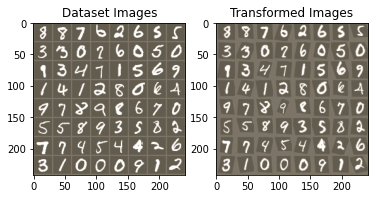

In [ ]:
def tensor_to_image(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    #Scale normalization of input
    return inp

def visualizer():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = tensor_to_image(
            torchvision.utils.make_grid(input_tensor))

        out_grid = tensor_to_image(
            torchvision.utils.make_grid(transformed_input_tensor))

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 4 + 1):
    train(epoch)
    test()

visualizer()

plt.ioff()
plt.show()